In [8]:
import rioxarray
import xarray as xr
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import glob
from pyproj import CRS#, Transformer

from utils import u_interpolate_small as inter

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [3]:
files = glob.glob('/home/ck/DIR/cornkle/data/EUMDAC_MTG_TESTS/MTG_VIS_tifs/FCI_tif_NRT/*.tif')

In [16]:
with open("/home/ck/DIR/cornkle/data/EUMDAC_MTG_TESTS/domain_tifs/crs_proj_geostationary_MTG.txt", "r") as f:
    crs = CRS.from_proj4(f.read())
def read_geotiff(file):
    data = rioxarray.open_rasterio(file)
    data_rio = data.rio.write_crs(crs)
    data_reprojected = data_rio.rio.reproject("EPSG:4326")

    data_reprojected = data_reprojected.sel(x=slice(13,36), y=slice(-9, -35))
    data_reprojected = data_reprojected.where(data_reprojected.values<60000, other=0)
    
    #data = (data - np.min(data)) / (np.max(data) - np.min(data))*10
    #data = data.where((data>2) & (data<3))
    
    return data_reprojected.squeeze()

In [17]:
da_box = read_geotiff(files[120])

In [18]:
files[120]

'/home/ck/DIR/cornkle/data/EUMDAC_MTG_TESTS/MTG_VIS_tifs/FCI_tif_NRT/FCIL1HRFI_20241221T110112Z_20241221T110406Z_epct_36c25c86_FC.tif'

In [19]:
### CODE TO SAVE INITIAL PROJECTION
# # Use rioxarray to interpret CRS
# data_rio = da_tif.rio.write_crs(da['geostationary'].attrs['crs_wkt'])

# # Check the CRS
# print(data_rio.rio.crs)

# # Reproject to WGS84 (EPSG:4326) if necessary
# data_reprojected = data_rio.rio.reproject("EPSG:4326")

# # Save as PROJ String
# with open("/home/ck/DIR/cornkle/data/EUMDAC_MTG_TESTS/domain_tifs/crs_proj_geostationary_MTG.txt", "w") as f:
#     f.write(data_rio.rio.crs.to_proj4())

/home/ck/miniforge3/envs/general/lib/python3.13/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


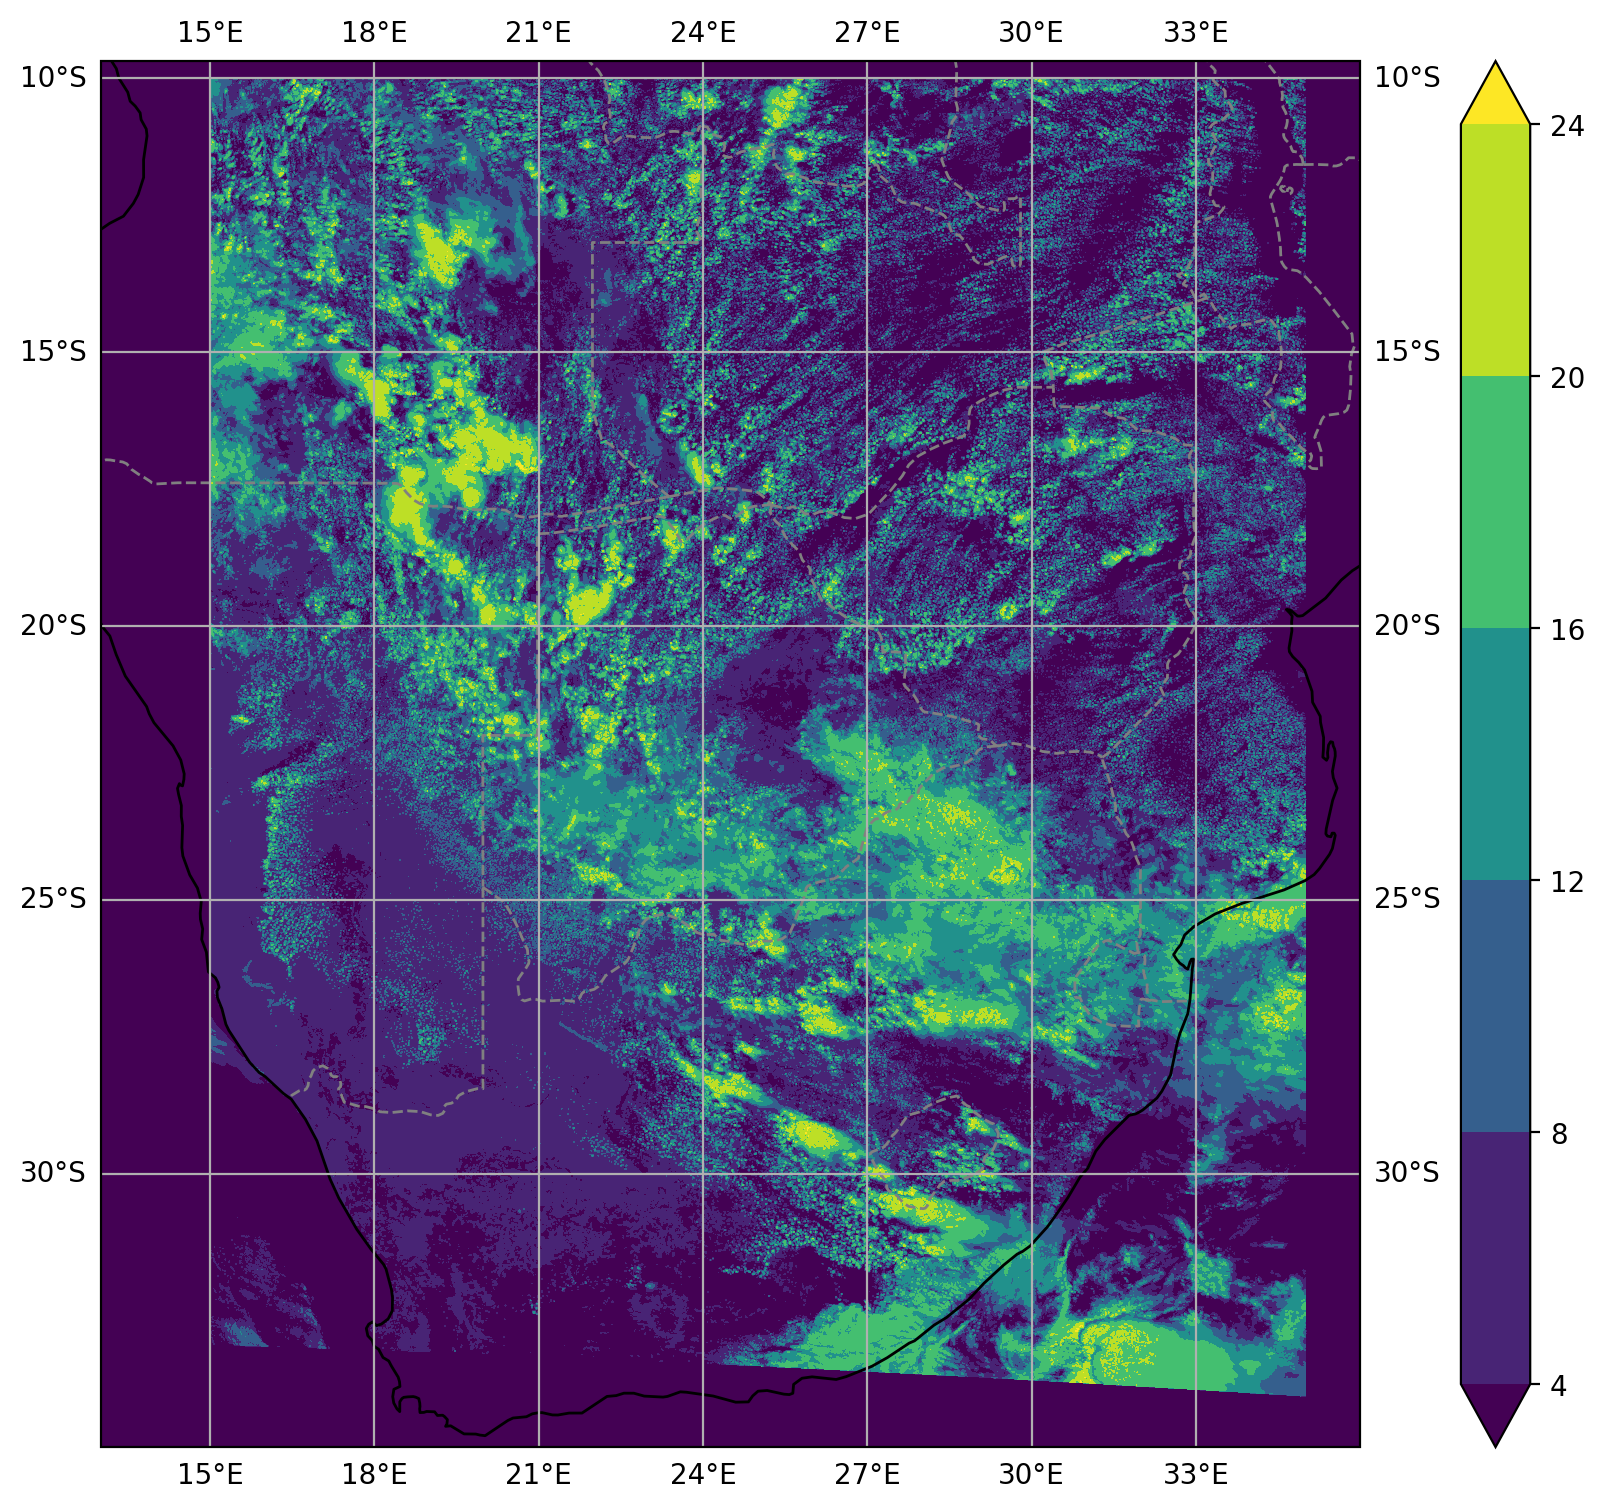

In [20]:
f = plt.figure(figsize=(13,9), dpi=200)
ax = f.add_subplot(111, projection=ccrs.PlateCarree())
plt.contourf(da_box.x.values, da_box.y.values, da_box, transform=ccrs.PlateCarree(), cmap='viridis', extend='both')
ax.coastlines()

xl = ax.gridlines(draw_labels=True);

# Countries
ax.add_feature(cartopy.feature.BORDERS, linestyle='--', color='grey');

cbar = plt.colorbar()

In [21]:
xmax, xmin = np.max(da_box.x), np.min(da_box.x)
ymax, ymin = np.max(da_box.y), np.min(da_box.y)

# create new coordinates going from ~500m to ~2km by dividing by 4
new_x = np.linspace(xmin.values, xmax.values, int(len(da_box.x)/4))
new_y = np.linspace(ymin.values, ymax.values, int(len(da_box.y)/4))

In [ ]:
# usual interpolation routine, input is not irregular (needs to run only once, repeat use of inds, weights shape possible without recalculation)
inds, weights, shape = inter.interpolation_weights(da_box.x.values, da_box.y.values, new_x, new_y, irregular_1d=False)

In [32]:
# read reprojected data as numpy array
data_2km = inter.interpolate_data(da_box.values, inds, weights, shape)

In [70]:
# convert to data array for subsetting
da_2km = xr.DataArray(data_2km,
    coords={"y": new_y, "x": new_x},
    dims=["y", "x"],
)

In [ ]:
#subset to portal visualisation domain (remove edges)
da_2km = da_2km.sel(y=slice(-33,-10), x=slice(15,35))

/home/ck/miniforge3/envs/general/lib/python3.13/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


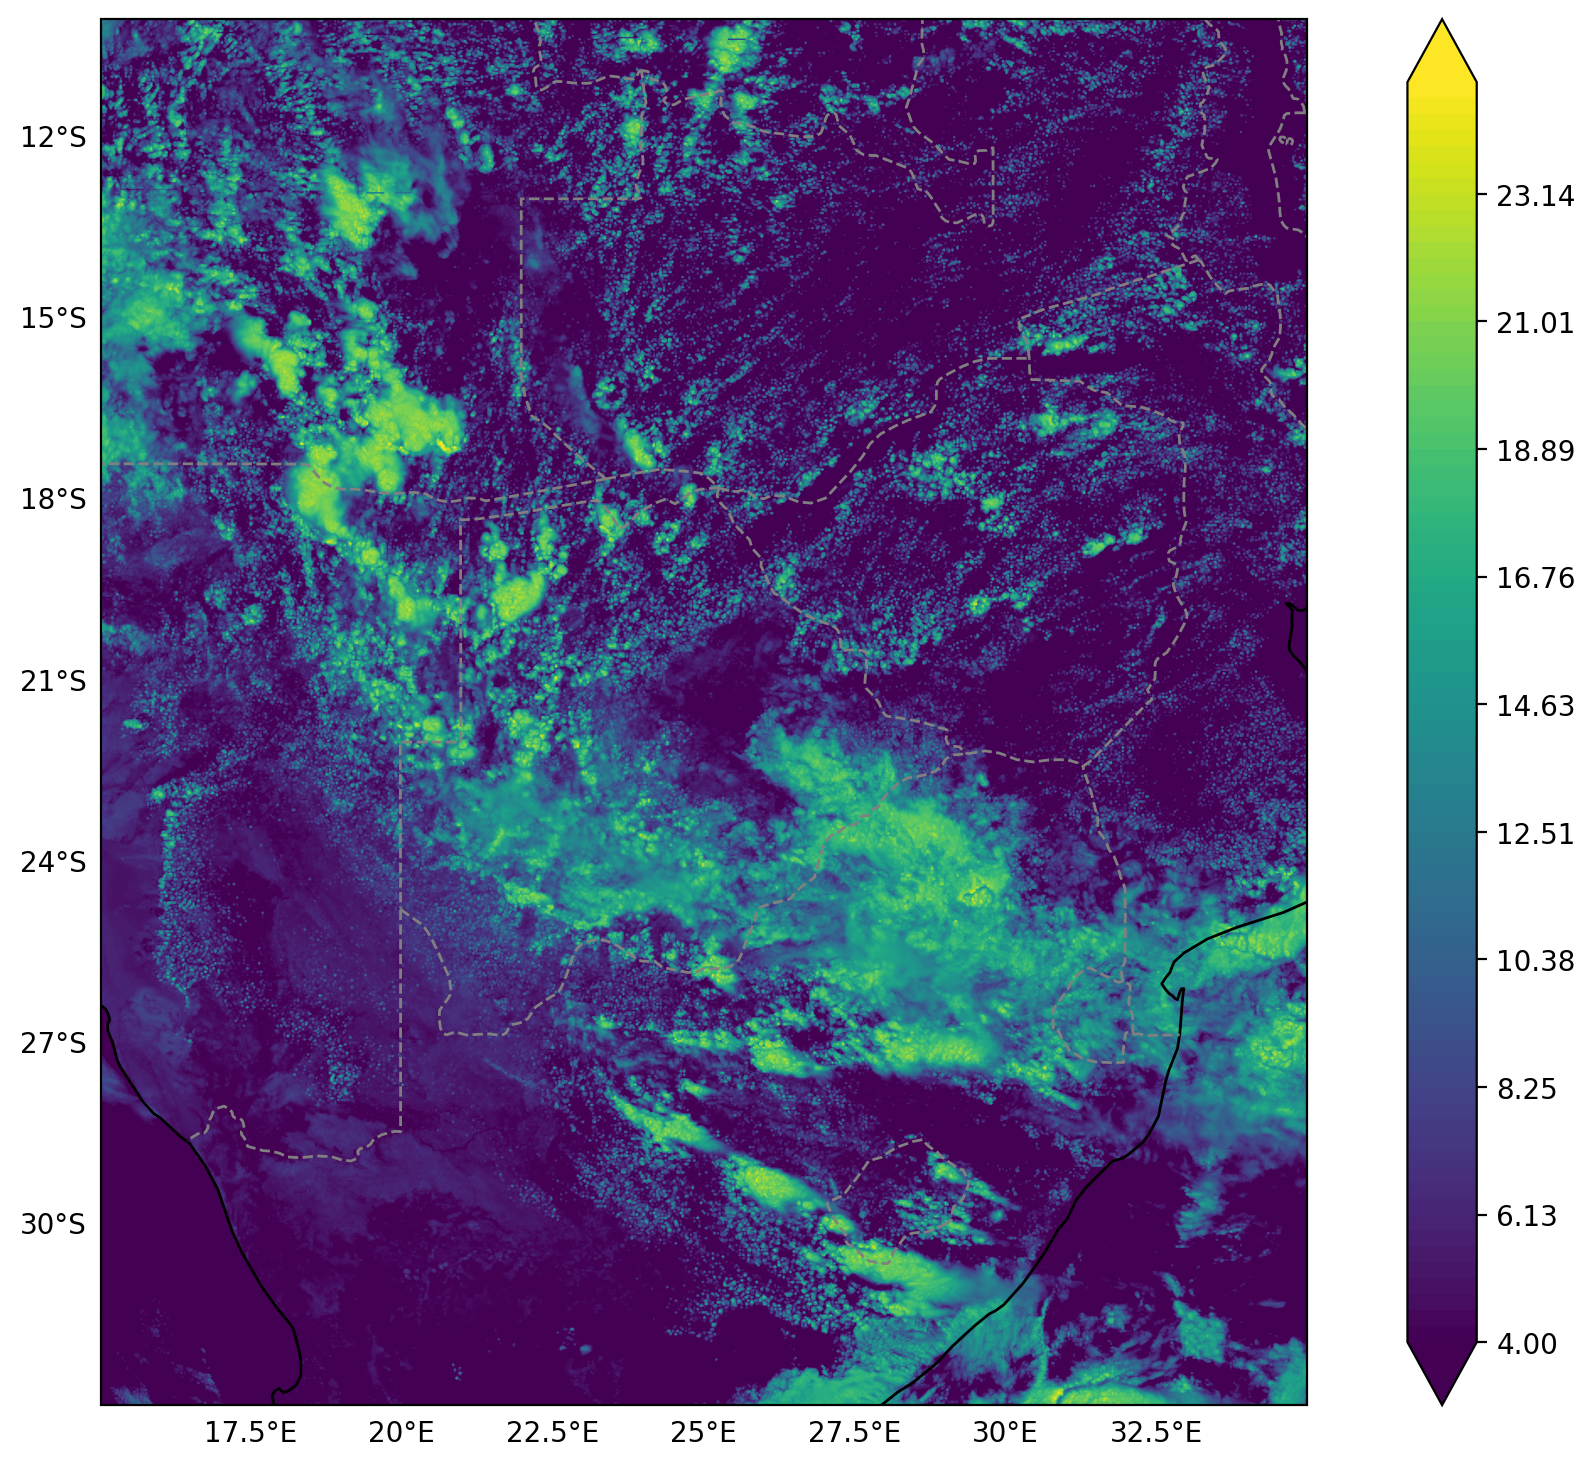

In [76]:
# Array to plot for portal upload

f = plt.figure(figsize=(13,9), dpi=200)
ax = f.add_subplot(111, projection=ccrs.PlateCarree())
plt.contourf(da_2km.x.values, da_2km.y.values, da_2km, transform=ccrs.PlateCarree(), cmap='viridis', extend='both', levels=np.linspace(4,25,80))
ax.coastlines()

xl = ax.gridlines(draw_labels=True);
xl.top_labels = False
xl.right_labels = False
xl.xlines = False
xl.ylines=False
# Countries
ax.add_feature(cartopy.feature.BORDERS, linestyle='--', color='grey');

cbar = plt.colorbar()